In [1]:
import tensorflow as tf 

import tensorflow_datasets as tfds 
DATA_DIR = "./tensorflow-datasets"


In [2]:
for_vocabulary = tfds.load("imdb_reviews", split="train", with_info=False, as_supervised=True, data_dir=DATA_DIR)
train_ds,val_ds = tfds.load('imdb_reviews', split=["train[:70%]","train[70%:]"], with_info=False,
                          as_supervised=True,data_dir=DATA_DIR)

# train_dataset, test_dataset = dataset['train'], dataset['test']

# train_dataset.element_spec

2024-11-10 08:21:59.347840: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 08:22:02.141529: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30972 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


In [3]:
len(train_ds), len(val_ds), len(for_vocabulary)

(17500, 7500, 25000)

In [4]:
# BATCH_SIZE=64
# BUFFER_SIZE=10000
# train_batched = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# val_batched = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [5]:
for example, label in train_ds.take(1):
    print(example.numpy())

2024-11-10 08:22:02.615277: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."


2024-11-10 08:22:02.831114: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [6]:
# length = for_vocabulary.map(lambda text,label: len(tf.strings.split(text," ")))

In [7]:
import re
import string
import numpy as np
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

def get_text_vectorizer(dataset, vocab_size=1000, sequence_length=500):
    vectorizer = tf.keras.layers.TextVectorization(standardize=custom_standardization, max_tokens=vocab_size,output_mode='int',output_sequence_length=sequence_length)
    vectorizer.adapt(dataset.map(lambda text,label: text))
    return vectorizer 

def train_model(model, train_ds, val_ds, loss_fn, batch_size=64, optimizer=tf.keras.optimizers.Adam(), callbacks=None, epochs=50):
    train_batched = train_ds.shuffle(1000).batch(batch_size)
    val_batched = val_ds.shuffle(1000).batch(batch_size)
    model.compile(loss=loss_fn, optimizer=optimizer,
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])
    history = model.fit(train_batched, epochs=epochs, validation_data=val_batched,callbacks=callbacks)
    return history

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 
def evaluate_model(model, val_ds, result_path=None):
    val_batched = val_ds.batch(64)
    predictions = (tf.nn.sigmoid(model.predict(val_batched)) > 0.5).numpy()
    truth = np.concatenate([label.numpy() for _,label in val_batched],axis=0)
    accuracy = accuracy_score(truth, predictions)
    ConfusionMatrixDisplay.from_predictions(y_pred=predictions, y_true=truth,normalize="true")
    if result_path:
        plt.savefig(result_path.joinpath('confusion_matrix.jpg'))
        plt.close()
    else:
        plt.show()
    return accuracy 
    
def plot_training_graphs(history, result_path=None):
    plt.plot(history.history['loss'],label="training")
    plt.plot(history.history['val_loss'],label="validation")
    plt.xlabel("epochs")
    if result_path:
        plt.savefig(result_path.joinpath('training_history.jpg'))
        plt.close()
    else:
        plt.show()
    

In [8]:
# Add attention layer to the deep learning network
import keras.backend as K
class Attention(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(Attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(Attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context =K.sum(context, axis=1)
        return context
    
    
def get_bidirectional_lstm_attention(vectorizer,kernel_regularizer=None, use_dropout=False):
    input = tf.keras.layers.Input(shape=[None],dtype=tf.string)
    vocab_len = len(vectorizer.get_vocabulary())
    x = vectorizer(input)
    x = tf.keras.layers.Embedding(input_dim=vocab_len, output_dim=64, mask_zero=True,name="embedding")(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True,kernel_regularizer=kernel_regularizer), name="bi_lstm_0")(x)
    # x, forward_h, forward_c, backward_h, backward_c = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True, return_state=True), name="bi_lstm_0")(x)
    # x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True,kernel_regularizer=kernel_regularizer), name="bi_lstm_1")(x)
    x = Attention()(x)
    # x = tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=kernel_regularizer )(x)
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=kernel_regularizer)(x)
    if use_dropout:
        x = tf.keras.layers.Dropout(rate=0.2)(x)
    x = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs=input,outputs=x)


def get_bidirectional_gru_attention(vectorizer,kernel_regularizer=None, use_dropout=False):
    input = tf.keras.layers.Input(shape=[None],dtype=tf.string)
    vocab_len = len(vectorizer.get_vocabulary())
    x = vectorizer(input)
    x = tf.keras.layers.Embedding(input_dim=vocab_len, output_dim=64, mask_zero=True,name="embedding")(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True,kernel_regularizer=kernel_regularizer), name="bi_gru_0")(x)
    # x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True,kernel_regularizer=kernel_regularizer), name="bi_lstm_0")(x)
    # x, forward_h, forward_c, backward_h, backward_c = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True, return_state=True), name="bi_lstm_0")(x)
    
    x = Attention()(x)
    
    # x = tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=kernel_regularizer )(x)
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=kernel_regularizer)(x)
    if use_dropout:
        x = tf.keras.layers.Dropout(rate=0.2)(x)
    x = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(inputs=input,outputs=x)

    

In [9]:
vectorizer = get_text_vectorizer(for_vocabulary,vocab_size=30000)

In [11]:
#experiment 1
import pandas as pd
from pathlib import Path 
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# vectorizer = get_text_vectorizer(for_vocabulary)
model_fn = get_bidirectional_gru_attention
result_dir = Path("./results_gru")
exp_results = []
print("vectorizer loaded")
for batch_size in [32,64]:
    for learning_rate in [0.01,0.001]:
        for regularizer in [True, False]:
            s_result = {'batch_size':batch_size,'learning_rate':learning_rate,'regularizer':regularizer}
            folder_name = f"{batch_size}_{learning_rate}_{regularizer}"
            result_path = result_dir.joinpath(folder_name)
            result_path.mkdir(parents=True,exist_ok=True)
            print("Working on",folder_name)
            reg = tf.keras.regularizers.l2() if regularizer else None
            model = model_fn(vectorizer=vectorizer,kernel_regularizer=reg,use_dropout=regularizer)
            print(model.summary())
            early_callback = tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            history = train_model(model, train_ds, val_ds, loss_fn, batch_size=batch_size, optimizer=optimizer, callbacks=[early_callback],epochs=200)
            accuracy = evaluate_model(model, val_ds,result_path=result_path)
            plot_training_graphs(history, result_path)
            print("For",folder_name,"accuracy",accuracy,"early_stopping", early_callback.best)
            s_result['accuracy'] = accuracy
            s_result['logs'] = history.history 
            model.save_weights(result_path.joinpath("best_weights.hd5"))
            model.save(result_path.joinpath("best_model.hd5"))
            # print("Accuracy on validation", accuracy)
            # break
            s_result['model'] = result_path.joinpath("best_model.hd5")
            exp_results.append(s_result)
            del model
pd.DataFrame(exp_results).to_csv("./results_gru/exp_results.csv")



vectorizer loaded
Working on 32_0.01_True
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
text_vectorization (TextVect (None, 500)               0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 64)           1920000   
_________________________________________________________________
bi_gru_0 (Bidirectional)     (None, 500, 128)          49920     
_________________________________________________________________
attention_4 (Attention)      (None, 128)               628       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropou

INFO:tensorflow:Assets written to: results_gru/32_0.01_True/best_model.hd5/assets


INFO:tensorflow:Assets written to: results_gru/32_0.01_True/best_model.hd5/assets


Working on 32_0.01_False
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
text_vectorization (TextVect (None, 500)               0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 64)           1920000   
_________________________________________________________________
bi_gru_0 (Bidirectional)     (None, 500, 128)          49920     
_________________________________________________________________
attention_5 (Attention)      (None, 128)               628       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None

KeyboardInterrupt: 

In [ ]:
#experiment 1
import pandas as pd
from pathlib import Path 
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# vectorizer = get_text_vectorizer(for_vocabulary)
model_fn = get_bidirectional_lstm_attention
result_dir = Path("./results_lstm")
exp_results = []
print("vectorizer loaded")
for batch_size in [32,64]:
    for learning_rate in [0.01,0.001]:
        for regularizer in [True, False]:
            s_result = {'batch_size':batch_size,'learning_rate':learning_rate,'regularizer':regularizer}
            folder_name = f"{batch_size}_{learning_rate}_{regularizer}"
            result_path = result_dir.joinpath(folder_name)
            result_path.mkdir(parents=True,exist_ok=True)
            print("Working on",folder_name)
            reg = tf.keras.regularizers.l2() if regularizer else None
            model = model_fn(vectorizer=vectorizer,kernel_regularizer=reg,use_dropout=regularizer)
            print(model.summary())
            early_callback = tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            history = train_model(model, train_ds, val_ds, loss_fn, batch_size=batch_size, optimizer=optimizer, callbacks=[early_callback],epochs=200)
            accuracy = evaluate_model(model, val_ds,result_path=result_path)
            plot_training_graphs(history, result_path)
            print("For",folder_name,"accuracy",accuracy,"early_stopping", early_callback.best)
            s_result['accuracy'] = accuracy
            s_result['logs'] = history.history 
            model.save_weights(result_path.joinpath("best_weights.hd5"))
            model.save(result_path.joinpath("best_model.hd5"))
            # print("Accuracy on validation", accuracy)
            s_result['model'] = result_path.joinpath("best_model.hd5")

            # break
            exp_results.append(s_result)
            del model
pd.DataFrame(exp_results).to_csv("./results_lstm/exp_results.csv")



In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
#
import main
import model
import util
import tensorflow as tf

In [2]:
train_ds, val_ds = util.get_train_val_ds()
vocab = util.get_for_vocab_ds()


2024-11-10 15:42:51.264616: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 15:42:54.137185: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30972 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


In [3]:
len(train_ds),len(val_ds)

(15000, 10000)

In [4]:
vectorizer = util.get_text_vectorizer(vocab, vocab_size=30000,sequence_length=1200)


2024-11-10 15:42:54.595707: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [ ]:
model_fn = model.get_bidirectional_lstm_attention
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
results_l = main.run_experiment(model_fn, train_ds, val_ds, loss_fn, vectorizer, "./results_lstm_")


Working on 32_0.01_True
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 1200)         0           input_10[0][0]                   
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1200, 64)     1920000     text_vectorization[9][0]         
__________________________________________________________________________________________________
attention_9 (Attention)         (None, 1200, 64)     0           embedding[0][0]                  
                                                                 emb

INFO:tensorflow:Assets written to: results_lstm_/32_0.01_True/best_model.hd5/assets


INFO:tensorflow:Assets written to: results_lstm_/32_0.01_True/best_model.hd5/assets


Working on 32_0.01_False
None
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 1200)         0           input_11[0][0]                   
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1200, 64)     1920000     text_vectorization[10][0]        
__________________________________________________________________________________________________
attention_10 (Attention)        (None, 1200, 64)     0           embedding[0][0]                  
                                                             

INFO:tensorflow:Assets written to: results_lstm_/32_0.01_False/best_model.hd5/assets


INFO:tensorflow:Assets written to: results_lstm_/32_0.01_False/best_model.hd5/assets


Working on 32_0.001_True
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 1200)         0           input_12[0][0]                   
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1200, 64)     1920000     text_vectorization[11][0]        
__________________________________________________________________________________________________
attention_11 (Attention)        (None, 1200, 64)     0           embedding[0][0]                  
                                                                 e

INFO:tensorflow:Assets written to: results_lstm_/32_0.001_True/best_model.hd5/assets


INFO:tensorflow:Assets written to: results_lstm_/32_0.001_True/best_model.hd5/assets


Working on 32_0.001_False
None
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 1200)         0           input_13[0][0]                   
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1200, 64)     1920000     text_vectorization[12][0]        
__________________________________________________________________________________________________
attention_12 (Attention)        (None, 1200, 64)     0           embedding[0][0]                  
                                                            

INFO:tensorflow:Assets written to: results_lstm_/32_0.001_False/best_model.hd5/assets


INFO:tensorflow:Assets written to: results_lstm_/32_0.001_False/best_model.hd5/assets


Working on 32_0.0001_True
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 1200)         0           input_14[0][0]                   
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1200, 64)     1920000     text_vectorization[13][0]        
__________________________________________________________________________________________________
attention_13 (Attention)        (None, 1200, 64)     0           embedding[0][0]                  
                                                                 

INFO:tensorflow:Assets written to: results_lstm_/32_0.0001_True/best_model.hd5/assets


INFO:tensorflow:Assets written to: results_lstm_/32_0.0001_True/best_model.hd5/assets


Working on 32_0.0001_False
None
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 1200)         0           input_15[0][0]                   
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1200, 64)     1920000     text_vectorization[14][0]        
__________________________________________________________________________________________________
attention_14 (Attention)        (None, 1200, 64)     0           embedding[0][0]                  
                                                           

INFO:tensorflow:Assets written to: results_lstm_/32_0.0001_False/best_model.hd5/assets


INFO:tensorflow:Assets written to: results_lstm_/32_0.0001_False/best_model.hd5/assets


Working on 64_0.01_True
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 1200)         0           input_16[0][0]                   
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1200, 64)     1920000     text_vectorization[15][0]        
__________________________________________________________________________________________________
attention_15 (Attention)        (None, 1200, 64)     0           embedding[0][0]                  
                                                                 em

INFO:tensorflow:Assets written to: results_lstm_/64_0.01_False/best_model.hd5/assets


INFO:tensorflow:Assets written to: results_lstm_/64_0.01_False/best_model.hd5/assets


Working on 64_0.001_True
Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 1200)         0           input_18[0][0]                   
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1200, 64)     1920000     text_vectorization[17][0]        
__________________________________________________________________________________________________
attention_17 (Attention)        (None, 1200, 64)     0           embedding[0][0]                  
                                                                 e

INFO:tensorflow:Assets written to: results_lstm_/64_0.001_True/best_model.hd5/assets


INFO:tensorflow:Assets written to: results_lstm_/64_0.001_True/best_model.hd5/assets


Working on 64_0.001_False
None
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 1200)         0           input_19[0][0]                   
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1200, 64)     1920000     text_vectorization[18][0]        
__________________________________________________________________________________________________
attention_18 (Attention)        (None, 1200, 64)     0           embedding[0][0]                  
                                                            

INFO:tensorflow:Assets written to: results_lstm_/64_0.001_False/best_model.hd5/assets


INFO:tensorflow:Assets written to: results_lstm_/64_0.001_False/best_model.hd5/assets


Working on 64_0.0001_True
Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 1200)         0           input_20[0][0]                   
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1200, 64)     1920000     text_vectorization[19][0]        
__________________________________________________________________________________________________
attention_19 (Attention)        (None, 1200, 64)     0           embedding[0][0]                  
                                                                 

In [ ]:
model_fn = model.get_bidirectional_gru_attention
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
results_g = main.run_experiment(model_fn, train_ds, val_ds, loss_fn, vectorizer, "./results_gru_")

Working on 32_0.01_True
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 1200)         0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1200, 64)     1920000     text_vectorization[0][0]         
__________________________________________________________________________________________________
attention (Attention)           (None, 1200, 64)     0           embedding[0][0]                  
                                                                 embed

2024-11-10 15:43:26.884002: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8902
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /common/cse479/shared/envs/tensorflow-env/lib/python3.9/site-packages/tensorflow/python/../../../../libcublas.so.11: undefined symbol: cublasGetSmCountTarget


469/469 [==============================] - 37s 63ms/step - loss: 0.5419 - binary_accuracy: 0.7978 - val_loss: 0.4870 - val_binary_accuracy: 0.8142
Epoch 2/200
469/469 [==============================] - 28s 60ms/step - loss: 0.2490 - binary_accuracy: 0.9310 - val_loss: 0.4299 - val_binary_accuracy: 0.8529
Epoch 3/200
469/469 [==============================] - 28s 60ms/step - loss: 0.1551 - binary_accuracy: 0.9685 - val_loss: 0.5339 - val_binary_accuracy: 0.8540
Epoch 4/200
469/469 [==============================] - 28s 60ms/step - loss: 0.1391 - binary_accuracy: 0.9795 - val_loss: 0.5267 - val_binary_accuracy: 0.8603
Epoch 5/200
469/469 [==============================] - 28s 60ms/step - loss: 0.0984 - binary_accuracy: 0.9875 - val_loss: 0.7097 - val_binary_accuracy: 0.8535
Epoch 6/200
469/469 [==============================] - 28s 60ms/step - loss: 0.0961 - binary_accuracy: 0.9894 - val_loss: 1.0283 - val_binary_accuracy: 0.8224
Epoch 7/200
469/469 [==============================] - 28s

2024-11-10 15:50:15.106857: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: results_gru_/32_0.01_True/best_model.hd5/assets


INFO:tensorflow:Assets written to: results_gru_/32_0.01_True/best_model.hd5/assets


Working on 32_0.01_False
None
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 1200)         0           input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1200, 64)     1920000     text_vectorization[1][0]         
__________________________________________________________________________________________________
attention_1 (Attention)         (None, 1200, 64)     0           embedding[0][0]                  
                                                              

INFO:tensorflow:Assets written to: results_gru_/32_0.01_False/best_model.hd5/assets


INFO:tensorflow:Assets written to: results_gru_/32_0.01_False/best_model.hd5/assets


Working on 32_0.001_True
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 1200)         0           input_3[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1200, 64)     1920000     text_vectorization[2][0]         
__________________________________________________________________________________________________
attention_2 (Attention)         (None, 1200, 64)     0           embedding[0][0]                  
                                                                 em

INFO:tensorflow:Assets written to: results_gru_/32_0.001_True/best_model.hd5/assets


INFO:tensorflow:Assets written to: results_gru_/32_0.001_True/best_model.hd5/assets


Working on 32_0.001_False
None
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 1200)         0           input_4[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1200, 64)     1920000     text_vectorization[3][0]         
__________________________________________________________________________________________________
attention_3 (Attention)         (None, 1200, 64)     0           embedding[0][0]                  
                                                             

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



469/469 [==============================] - 28s 60ms/step - loss: 0.0142 - binary_accuracy: 0.9952 - val_loss: 0.7020 - val_binary_accuracy: 0.8656
Epoch 8/200
469/469 [==============================] - 28s 60ms/step - loss: 0.0111 - binary_accuracy: 0.9962 - val_loss: 0.4452 - val_binary_accuracy: 0.8642
Epoch 9/200
469/469 [==============================] - 28s 60ms/step - loss: 0.0085 - binary_accuracy: 0.9973 - val_loss: 0.7722 - val_binary_accuracy: 0.8680
Epoch 10/200
469/469 [==============================] - 28s 60ms/step - loss: 0.0033 - binary_accuracy: 0.9991 - val_loss: 0.8584 - val_binary_accuracy: 0.8660
Epoch 11/200
469/469 [==============================] - 28s 60ms/step - loss: 0.0072 - binary_accuracy: 0.9975 - val_loss: 0.8904 - val_binary_accuracy: 0.8662
For 32_0.001_False accuracy 0.8896 early_stopping 0.8866999745368958


INFO:tensorflow:Assets written to: results_gru_/32_0.001_False/best_model.hd5/assets


INFO:tensorflow:Assets written to: results_gru_/32_0.001_False/best_model.hd5/assets


Working on 32_0.0001_True
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 1200)         0           input_5[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1200, 64)     1920000     text_vectorization[4][0]         
__________________________________________________________________________________________________
attention_4 (Attention)         (None, 1200, 64)     0           embedding[0][0]                  
                                                                 e

NameError: name 'results_m' is not defined

In [ ]:
combined_results = results_l #pd.concat([results_l],reset_index=True, sort=False)
best_result = combined_results[combined_results['accuracy']==combined_results['accuracy'].max()]
weight_location = best_result['model']
if "lstm" in weight_location:
    f_model = model.get_bidirectional_lstm_attention(vectorizer)
else:
    f_model = model.get_bidirectional_gru_attention(vectorizer)
    
        
f_model.load_weights(weight_location)
test_ds = util.get_test_ds()
util.evaluate_model(f_model, test_ds, Path("./"))

In [25]:
best_model = model.get_bidirectional_lstm_attention(vectorizer)

None


In [34]:
best_model.load_weights("results_lstm_/32_0.001_True/best_weights.hd5")

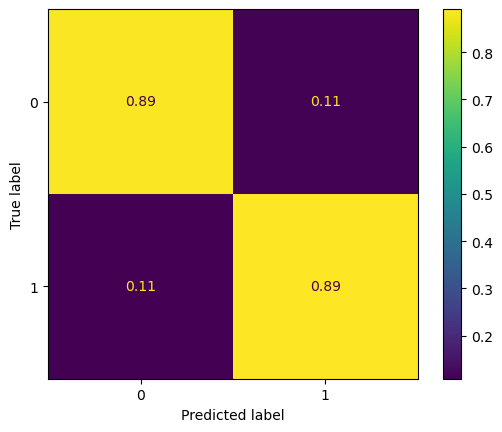

0.8889

In [35]:
test_ds = util.get_test_ds()
util.evaluate_model(best_model, val_ds)

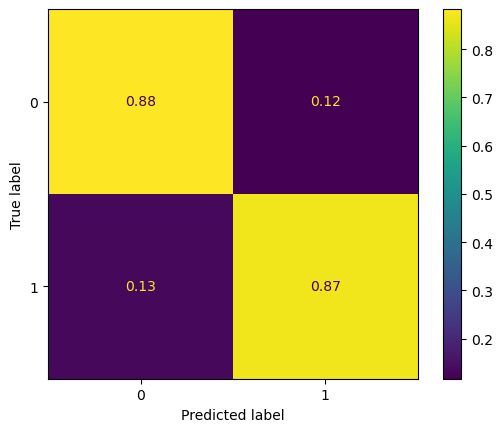

0.87552

In [36]:
util.evaluate_model(best_model, test_ds)